<a href="https://colab.research.google.com/github/jdlozanom/deep-learning-experiments/blob/master/Voice_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Updated notebook at repository: https://github.com/jdlozanom/deep-learning-experiments/blob/master/Voice_recognition.ipynb

# Init

In [0]:
!pip install pytube3
!pip install -U librosa

Requirement already up-to-date: librosa in /usr/local/lib/python3.6/dist-packages (0.7.2)


In [0]:
from pytube import YouTube
import os
import matplotlib.pyplot as plt
import librosa
import numpy as np
import librosa.display
import pandas as pd

import IPython
from IPython.display import Audio

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Video download

In [0]:
videos_dict = {
    "errejon" : ['AjiHJNRz7BQ', 'yQzapET06cA', 'mt1YrvamC9c'],
    "casado" : ['hn5RYH94O74', 'HJZJIEJBwHU', 'yfqQ2YSculg'],
    "sanchez" : ['TdUuzUR_mBM', '1t53omZSGwY','54jcoRjqJnw'],
    "arrimadas" : ['eK13K9wpSmw','hLCQvH5iiA8','9k3S1P6yU_k'],
    "abascal" : ['8Kufi9BxLI4','NgdEwEf9Imk','WTYHTHFCvL0'],
    "iglesias" : ['Dp-1lAoMd5I','_hFm83S1RaE','QcIt1F8oUS4']
}

In [0]:
def dowload_video(video_list):
  for video_name in video_list:
    video = YouTube('https://www.youtube.com/watch?v={}'.format(video_name))
    video.streams.filter(type = "audio", file_extension = "mp4").all()[0].download(filename=video_name)

In [0]:
keys = list(videos_dict.keys())
for k in keys:
  dowload_video(videos_dict[k])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function all (This object can be treated 

In [0]:
VIDEOS_PATH = '.'
VIDEOS_EXTENSION = '.mp4' 
AUDIO_EXT = 'wav'

EXTRACT_VIDEO_COMMAND = ('ffmpeg -i "{from_video_path}" '
                         '-f {audio_ext} -ab 32k -ac 1 '
                         '-vn "{to_audio_path}"')

os.chdir(VIDEOS_PATH)
files = os.listdir(VIDEOS_PATH)
for f in files:
    if not f.endswith(VIDEOS_EXTENSION):
        continue

    audio_file_name = '{}.{}'.format(f[:-len(VIDEOS_EXTENSION)], AUDIO_EXT)
    command = EXTRACT_VIDEO_COMMAND.format(
        from_video_path=f, audio_ext=AUDIO_EXT, to_audio_path=audio_file_name,
    )
    os.system(command)

os.system('rm *mp4')

0

# Data Exploration

In [0]:
y, sr = librosa.load('TdUuzUR_mBM.wav')
S = librosa.feature.melspectrogram(y=y, sr=sr)

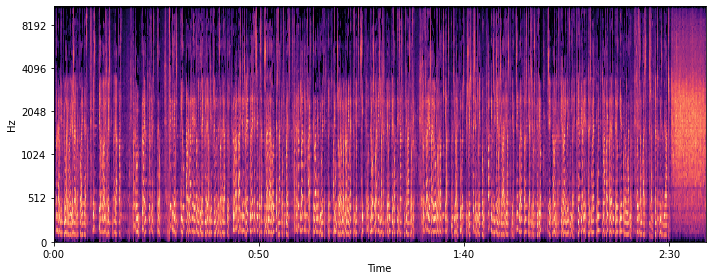

In [0]:
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                       y_axis='mel', sr=sr)

plt.tight_layout()
plt.show()

In [0]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128)
mfccsscaled = np.mean(mfccs.T,axis=1)

df = pd.DataFrame(mfccs[:,0:128])
df = pd.DataFrame(mfccs)
df

NameError: ignored

In [0]:
#df_out = df.loc[:,df.iloc[0] != -480.182159]
df_out = df.loc[:,df.iloc[0] > mfccs.min()*3/5]

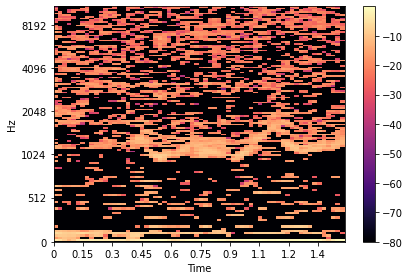

In [0]:
#librosa.display.specshow(df_out.values[:,0:128], x_axis='time')
S_dB = librosa.power_to_db(df_out.values[:,:64], ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                       y_axis='mel', sr=sr)

plt.colorbar()
plt.tight_layout()
plt.show()

In [0]:
audio = librosa.feature.inverse.mfcc_to_audio(df_out.values[:,0:64])
librosa.output.write_wav('new.wav', audio, sr=21500)
IPython.display.display(Audio('new.wav'))

/usr/local/lib/python3.6/dist-packages/librosa/output.py:198: DeprecationWarning: librosa.output.write_wav
	Deprecated as of librosa version 0.7.0.
	It will be removed in librosa version 0.8.
  def write_wav(path, y, sr, norm=False):


# Data prep


In [0]:
X = []
y = []

keys = list(videos_dict.keys())
for person_id, person in enumerate(keys):
  for audio_id in videos_dict[person]:
    print(person_id, person, audio_id)
    audio_ts, sr = librosa.load(f'{audio_id}.wav')
    mfccs = librosa.feature.mfcc(y=audio_ts, sr=sr, n_mfcc=128)
    df = pd.DataFrame(mfccs)
    df_out = df.loc[:,df.iloc[0] > mfccs.min()*3/5]

    audio_len = mfccs.shape[1]
    for i in range(0, audio_len - (audio_len // 5), 64):
      X.append(mfccs[:,i:i+64].ravel())
      y.append(person_id)

0 errejon AjiHJNRz7BQ
0 errejon yQzapET06cA
0 errejon mt1YrvamC9c
1 casado hn5RYH94O74
1 casado HJZJIEJBwHU
1 casado yfqQ2YSculg
2 sanchez TdUuzUR_mBM
2 sanchez 1t53omZSGwY
2 sanchez 54jcoRjqJnw
3 arrimadas eK13K9wpSmw
3 arrimadas hLCQvH5iiA8
3 arrimadas 9k3S1P6yU_k
4 abascal 8Kufi9BxLI4
4 abascal NgdEwEf9Imk
4 abascal WTYHTHFCvL0
5 iglesias Dp-1lAoMd5I
5 iglesias _hFm83S1RaE
5 iglesias QcIt1F8oUS4


In [0]:
pd.DataFrame(X)

0           1           2     ...      8189      8190      8191
0    -480.182159 -480.182159 -290.081421  ... -2.417505 -2.011077 -2.148685
1    -153.203079  -91.830849  -81.569115  ... -0.352966  0.537003 -0.170284
2    -122.322136 -122.474609 -129.054276  ...  0.485672  0.350182  1.302803
3    -120.821320 -138.726959 -177.980286  ... -0.183434  1.206665  0.934578
4    -191.528015 -183.144257 -203.421097  ... -0.711700 -1.378464 -1.118797
...          ...         ...         ...  ...       ...       ...       ...
4681 -272.349609 -267.544403 -277.918823  ... -0.937176 -1.265820 -0.309921
4682 -254.406891 -281.352478 -313.702271  ...  0.935677  2.001877 -1.126808
4683 -260.454956 -210.725632 -218.884933  ...  2.211506  0.905266  0.971741
4684 -361.829620 -336.757294 -341.159515  ...  0.867004  0.592533  1.063091
4685  -98.502121  -73.622368  -82.786964  ...  0.823746  0.058846  0.853920

[4686 rows x 8192 columns]

In [0]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

transformer = Normalizer().fit(X)

X_train, X_test, y_train, y_test = train_test_split(transformer.transform(X), y, test_size=0.33, random_state=42)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)

print(neigh.predict(X_test))
#y_test


[5 5 1 5 5 1 5 1 5 5 3 5 3 5 3 5 3 1 1 5 5 3 5 3 5 5 5 3 5 1 4 5 5 5 5 3 5
 5 1 1 1 3 1 1 5 5 3 5 3 5 5 5 3 5 5 3 5 5 1 5 5 2 5 1 5 1 5 5 5 1 5 5 1 5
 3 4 5 5 1 5 1 5 5 5 5 5 5 1 5 1 5 5 5 5 1 3 5 5 5 5 5 3 5 4 5 3 3 5 5 4 1
 1 5 5 5 5 3 5 5 5 5 5 5 3 5 5 3 5 5 5 5 3 1 1 1 4 4 3 1 5 5 1 4 1 5 3 5 5
 1 5 1 1 5 5 1 5 5 5 1 5 1 5 5 5 5 3 5 3 1 1 1 5 1 1 1 5 5 5 3 5 5 3 5 5 1
 5 5 1 5 4 5 5 5 2 5 5 5 5 3 5 5 5 3 5 1 5 1 1 5 5 5 3 5 3 5 3 5 5 3 5 5 5
 3 3 1 3 3 5 3 3 3 5 5 3 1 5 1 5 3 5 3 3 1 4 1 5 5 1 1 3 5 5 1 5 5 3 5 1 5
 3 1 3 1 5 5 1 3 5 5 3 5 3 5 5 1 3 1 1 5 5 1 1 5 5 5 1 3 5 3 5 5 1 5 3 5 5
 5 5 1 4 5 3 5 3 5 5 5 4 5 5 5 1 5 5 5 5 1 3 3 1 1 5 5 1 5 5 1 5 3 1 5 5 5
 5 3 5 5 5 5 1 1 1 3 5 5 5 3 3 3 3 5 5 5 1 5 3 5 3 5 3 3 5 5 5 5 5 5 1 5 3
 1 5 5 1 5 5 3 5 5 1 3 5 5 1 3 5 1 5 5 5 3 5 5 5 5 3 5 1 5 5 5 5 5 3 1 3 5
 1 5 1 5 1 5 3 5 5 5 1 5 5 5 5 5 5 5 5 5 5 3 5 5 3 5 5 3 5 5 5 3 5 5 3 5 1
 5 1 5 5 5 1 5 5 5 5 1 5 1 5 5 1 5 1 5 5 2 5 1 5 5 5 0 5 5 5 5 1 1 5 1 1 5
 3 5 1 5 1 3 5 1 3 5 1 5 

In [0]:
from sklearn.metrics import accuracy_score
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.7734806629834254

# Keras

In [0]:
y_train2 = keras.utils.to_categorical(y_train, 6)
y_test2 = keras.utils.to_categorical(y_test, 6)

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(Dense(100,input_shape=(64*128,),activation='sigmoid'))
model.add(Dense(6, activation='softmax'))

print(model.summary())
EPOCH = 50
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train2, validation_data=(X_test, y_test2), epochs=EPOCH, batch_size=256, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               819300    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 819,906
Trainable params: 819,906
Non-trainable params: 0
_________________________________________________________________
None
Train on 3139 samples, validate on 1547 samples
Epoch 1/50
3139/3139 [==============================] - 1s 248us/step - loss: 1.9131 - accuracy: 0.1749 - val_loss: 1.7271 - val_accuracy: 0.4376
Epoch 2/50
3139/3139 [==============================] - 1s 167us/step - loss: 1.6940 - accuracy: 0.3259 - val_loss: 1.6810 - val_accuracy: 0.2495
Epoch 3/50
3139/3139 [==============================] - 1s 163us/step - loss: 1.6457 - accuracy: 0.2730 - val_loss: 1.6330 - val_accuracy: 0.2799
Epoch 4/50
3139/313